# Solution to problem set 2   
# course Building a Robot Judge  Prof E Ash ETHZ  
# due date 18 Apr 2019  submitted by Heman Tanos tanosh@student.ethz.ch

In [263]:
import numpy as np

import csv
import pandas as pd
import os
from datetime import time 
from datetime import datetime
import matplotlib.pyplot as plt

from string import punctuation
translator = str.maketrans(' ', ' ', punctuation)
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')


In [264]:
def normalize_text(doc):                # taken from past problem set     see comment under question 3
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ') 
        lower = sent.lower()
        nopunc = lower.translate(translator)
        words = nopunc.split()
        nostop = [w for w in words if w not in stoplist]
        no_numbers = [w if not w.isdigit() else '#' for w in nostop]
        stemmed = [stemmer.stem(w) for w in no_numbers]
        tokens += stemmed
    return tokens


In [265]:
df = pd.DataFrame(index = range(0,0), columns=['jahr',  'rev', 'jid', 'logcites', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes', 'tgs'], 
                  dtype = int)
df['tgs'] = df['tgs'].astype('object')  # tgs is a list of trigrams
df['logcites'] = df['logcites'].astype('object')  # strings

fpath = '/home/xhta/Robot/cases'   # !!!!!! this path must be modified to point to the folder where the cases are located (texts)

lrev = []	#list of reversed cases   
lnrev = []	#list of not reversed cases

print ("reading in case_metadata.txt")
with open ("/home/xhta/Robot/case_metadata.csv") as fcrev:
    readCSV = csv.reader(fcrev, delimiter = ',')
    next(readCSV, None)   # skip 1 line   don't skip in case of 96  only skip in the orig
    for Zei in readCSV:
        if (Zei[1] == '0'): lnrev.append(Zei[0])      # lnrev gets populated here
        else: lrev.append(Zei[0])                     # lrev gets populated here
        df.loc[Zei[0]] = [Zei[3], Zei[1], Zei[2], Zei[4], 0, 0, 0, 0, 0, 0, [ ]]

df['jahr'] = pd.to_numeric(df['jahr'], errors = 'ignore')  # 
df['jid'] = pd.to_numeric(df['jid'], errors = 'ignore')  # 
df['rev'] = df['rev'].astype('int')	
print ("done reading in case_metadata.txt")

reading in case_metadata.txt
done reading in case_metadata.txt


In [266]:
n_samples = 1000   # !!!!!!!!!!!!!!!!!!! to be set from run to run !!!!!!!!!   1000 was suggested in the problem set
# run time is long when setting n_samples to 1000 (> 1 hour)
n_rev = len(lrev)  # the n_samples samples are composed in the same proportion of reversed/nonreversed cases as in the full corpus
n_nrev = len(lnrev)
n_all = n_rev + n_nrev

n_samples_rev = int(np.ceil(n_samples * n_rev/n_all))
n_samples_nrev = n_samples - n_samples_rev

samples_rev_caseid = np.random.choice(lrev, n_samples_rev, replace = False)
samples_nrev_caseid = np.random.choice(lnrev, n_samples_nrev, replace = False)

for inde in df.index:
    if (not inde in samples_nrev_caseid) & (not inde in samples_rev_caseid):
        df = df.drop(inde)    

#for caseid_nrev in samples_nrev_caseid:      # populate the index with the case ID  and the column 'rev' 
#    df.loc[caseid_nrev] = [0, 0, 0, 0, 0, 0, 0, 0, [ ]]

#for caseid_rev in samples_rev_caseid:
#    df.loc[caseid_rev] = [0, 1, 0, 0, 0, 0, 0, 0, [ ]]

#print ("done inserting caseid and rev into dataframe")

from os import listdir
from os.path import isfile, join

fnames = [f for f in listdir(fpath) if isfile(f)]

ldir = listdir(fpath)


In [267]:
len(df.index)

1000

In [268]:
import spacy                   #  initializing data structures used later
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

nlp2 = spacy.load('en_core_web_sm')

from nltk import ngrams
from collections import Counter
term_frequencies = Counter()

totalgrams = []

i = 0

In [269]:
for fname in ldir:            # read in the document samples and populate the dataframe
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    if (not (cname in df.index)): continue

    if ( i% 59 ==0):
        print(datetime.now().strftime('%Y%m%d_%H:%M:%S'))   # serves as a "progress bar" when reading in a large # of docs
    df.at[cname, 'jahr'] =  year
    i = i + 1
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    doc = nlp(rawtext)
    df.at[cname, 'nlets'] =  len(rawtext)
    sentences = [sent.string.strip() for sent in doc.sents]
    df.at[cname, 'nsents'] =  len(sentences)
    df.at[cname, 'nwords'] = len([token for token in doc if not token.is_punct])
    doc2 = nlp2(rawtext)
    df.at[cname, 'nnouns'] = len([w for w in list(doc2) if w.tag_.startswith('N')]) # PTB convention
    df.at[cname, 'nverbs'] = len([w for w in list(doc2) if w.tag_.startswith('V')])
    df.at[cname, 'nadjes'] = len([w for w in list(doc2) if w.tag_.startswith('J')])
    cltoks = normalize_text(doc2)
    ntoks = [str(token).lower() for token in list(doc2) if (token.tag_.startswith('N')) & (not token.is_punct) & (not token.is_space) & (not token.is_stop) & (str(token) in cltoks)]
    trigrams = ngrams(cltoks, 3)
    grams = []
    for t in trigrams:
        lt = list(t)
        if(lt[2] in ntoks): grams += ['_'.join(t)]
    df.at[cname, 'tgs'] = grams
    totalgrams += grams
    term_frequencies.update(cltoks)

print ("finished populating data frame")

20190411_10:18:19
20190411_10:21:26
20190411_10:24:56
20190411_10:28:20
20190411_10:31:09
20190411_10:34:00
20190411_10:36:23
20190411_10:40:00
20190411_10:42:46
20190411_10:45:41
20190411_10:47:42
20190411_10:49:15
20190411_10:51:21
20190411_10:53:51
20190411_10:55:59
20190411_10:58:10
20190411_11:00:23
finished populating data frame


In [275]:
df.head()

,jahr,rev,jid,logcites,nsents,nwords,nlets,nnouns,nverbs,nadjes,tgs
X3N6DO,1926.0,0,677.0,,15.0,367.0,2084.0,133.0,52.0,13.0,"[circuit_judg_suit, secur_issu_bond, subsequ_i..."
X3CEDR,1926.0,0,1024.0,0.6931471805599453,26.0,559.0,3179.0,188.0,91.0,20.0,"[#_jame_district, district_judg_appeal, state_..."
X3BD9F,1926.0,0,1591.0,1.0986122886681098,46.0,1706.0,9663.0,519.0,240.0,77.0,"[appel_incorpor_law, incorpor_law_state, oper_..."
X3IJOI,1925.0,0,NaN,,15.0,354.0,1865.0,98.0,53.0,19.0,"[curiam_affirm_judgment, gave_leav_trial, leav..."
X3LJCS,1928.0,0,NaN,,106.0,2140.0,11432.0,550.0,336.0,148.0,"[l_hand_circuit, judg_state_fact, state_fact_c..."


In [276]:
# df3 is a new dataframe with 1000 trigrams as features (the trigrams end with a noun)
n_feats = 1000          # !!!!!!!!!!!!!!!to be set as seen fit  !!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
tgc = Counter(totalgrams)
mc = tgc.most_common()[0:n_feats]
lmc = len(mc)

# df3 includes the targets/labels because need to do logisticregression later
feats = ['rev']
for j in range(lmc):
    tu = tgc.most_common()[j]
    fea = tu[0]
    feats.append(fea)

df3 = pd.DataFrame(index = df.index, columns=feats, dtype = int)
df3['rev'] = df['rev']     # populate the column 'rev'
df3 = df3.astype({"rev": int})
#pkl_fname = 'df3.' + datetime.now().strftime('%Y%m%d_%H%M%S' + ".pkl")
#df3.to_pickle(pkl_fname)
# save a a pickle for later use

In [278]:
# populate the dataframe df3 with the trigram frequencies
for loca in df.index:
    tgs = df.loc[loca, 'tgs']
    for feat in feats:
        if (feat == 'rev'): continue
        df3.at[loca, feat] = tgs.count(feat)

In [325]:
# apply LogisticRegression from sklearn on the training data set and make prediction
# using the training / test data set to compare the accuracy score / the F1 score

from sklearn import preprocessing

target = df3['rev']
features = df3.loc[:,df3.columns != 'rev']

features_scaled = preprocessing.scale(features, with_mean=False)
msk = np.random.rand(len(df3)) < 0.8      
# split into 80 % training set and 20% test set

# training set
targeta = target[msk]
feata = features_scaled[msk]

# test set
targete = target[~msk]
feate = features_scaled[~msk]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 123, solver = 'liblinear').fit(feata, targeta)

ypreda = clf.predict(feata)
yprede = clf.predict(feate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [326]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
accuracy_score(targeta, ypreda)  # accuracy on training data
accuracy_score(targete, yprede)  # accuracy on test data


0.53

In [280]:
# find the best LogisticRegressor for use in Question 1 in problem set 1
#from sklearn import grid_search, # deprecated
from sklearn import model_selection
parameters = {'penalty':('l1', 'l2'), 'C':[1, 2, 5, 10]}

#clf2 = grid_search.GridSearchCV(clf, parameters)
#clf2.fit(feata, targeta)
#clf2.best_params_

clf3 = model_selection.GridSearchCV(clf, parameters)
clf3.fit(feata, targeta)
clf3.best_params_

{'C': 1, 'penalty': 'l1'}

In [327]:
# to be used later to compare with neural network
ypreda3 = clf3.predict(feata)
yprede3 = clf3.predict(feate)

accuracy_score(targeta, ypreda3)  # accuracy on training data
accuracy_score(targete, yprede3)  # accuracy on test data


0.885

# problem set 2  Question 1 precision_recall_curve() and roc_curve()
# precision recall

In [281]:
y_score3 = clf3.decision_function(feate)

precision3, recall3, _ = precision_recall_curve(targete, y_score3)

Text(0.5,1,'Precision recall curve')

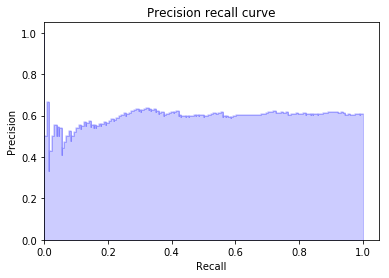

In [282]:
# plot precision recall curve
from sklearn.utils.fixes import signature

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall3, precision3, color = 'b', alpha = 0.2, where = 'post')
plt.fill_between(recall3, precision3, alpha = 0.2, color = 'b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('Precision recall curve')

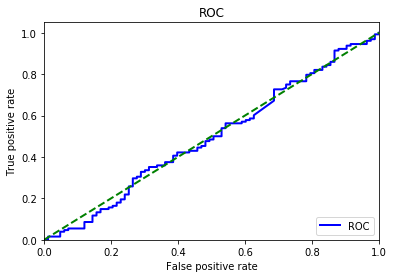

In [283]:
# plot roc curve
fpr, tpr, thr = roc_curve(targete, y_score3)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'blue', lw=lw, label = 'ROC')
plt.plot([0, 1], [0, 1], color = 'green', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [287]:
target = df3['rev']

In [289]:
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(clf3, X=features_scaled, y=target, cv=10)

In [290]:
Counter(y_pred_cv)

Counter({0: 368, 1: 632})

In [296]:
confusion_matrix(y_pred_cv, target)

array([[126, 242],
       [241, 391]])

In [293]:
# calibration plot
from sklearn.calibration import calibration_curve

#get the corrdinates of the bins
bin_y, bin_x = calibration_curve(target, y_pred_cv, n_bins=10)

In [294]:
bin_x, bin_y

(array([0., 1.]), array([0.6576087 , 0.61867089]))

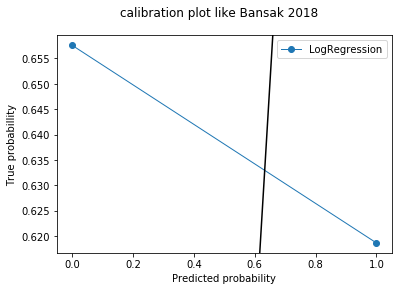

In [295]:
# plot the calibration curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

figu, ax = plt.subplots()

plt.plot(bin_x, bin_y, marker = 'o', linewidth = 1, label = 'LogRegression')
FortyFiveDegrees = mlines.Line2D([0,1], [0,1], color = 'black')
transform = ax.transAxes
ax.add_line(FortyFiveDegrees)
figu.suptitle('calibration plot like Bansak 2018')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probabillity')
plt.legend()
plt.show()

# is not very informative because this is a binary claasifier with only 2 outcomes, not continuous like in Bansak's paper

In [150]:
df['logcites'] = df['logcites'].fillna('0')

,jahr,rev,jid,logcites,nsents,nwords,nlets,nnouns,nverbs,nadjes,tgs
X9VC5V,1925.0,0,493.0,,9.0,223.0,1283.0,56.0,39.0,8.0,"[complain_brought_suit, rescind_subscript_stoc..."
X9VAJI,1925.0,0,NaN,,13.0,230.0,1258.0,69.0,30.0,11.0,"[per_curiam_collector, revenu_fifth_district, ..."
X3N6E3,1926.0,0,NaN,,3.0,7.0,30.0,3.0,1.0,0.0,[]
X3N6DN,1926.0,0,NaN,,3.0,9.0,44.0,4.0,1.0,0.0,[]
X9VC00,1925.0,0,2159.0,0.6931471805599453,50.0,2370.0,13314.0,701.0,338.0,77.0,"[circuit_judg_owner, judg_owner_oil, owner_oil..."


In [310]:
df['logcites'] = df['logcites'].convert_objects(convert_numeric=True)


/home/xhta/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [314]:
df['logcites'] = df['logcites'].fillna(0.0)


In [315]:
df.head()

,jahr,rev,jid,logcites,nsents,nwords,nlets,nnouns,nverbs,nadjes,tgs
X3N6DO,1926.0,0,677.0,0.000000,15.0,367.0,2084.0,133.0,52.0,13.0,"[circuit_judg_suit, secur_issu_bond, subsequ_i..."
X3CEDR,1926.0,0,1024.0,0.693147,26.0,559.0,3179.0,188.0,91.0,20.0,"[#_jame_district, district_judg_appeal, state_..."
X3BD9F,1926.0,0,1591.0,1.098612,46.0,1706.0,9663.0,519.0,240.0,77.0,"[appel_incorpor_law, incorpor_law_state, oper_..."
X3IJOI,1925.0,0,NaN,0.000000,15.0,354.0,1865.0,98.0,53.0,19.0,"[curiam_affirm_judgment, gave_leav_trial, leav..."
X3LJCS,1928.0,0,NaN,0.000000,106.0,2140.0,11432.0,550.0,336.0,148.0,"[l_hand_circuit, judg_state_fact, state_fact_c..."


# problem set 2: Question 2 elastic net

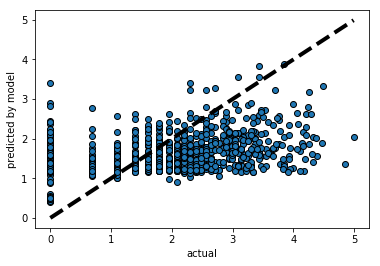

In [316]:
 
# feature scaling while maintaining sparsity done above 
# features_scaling = preprocessing.scale(feature, with_mean=False)
from sklearn.linear_model import ElasticNet
enet = ElasticNet(l1_ratio = 0.2, alpha=0.2)

ctarget = df['logcites']
ctargeta = ctarget[msk]
ctargete = ctarget[~msk]

enet.fit(features_scaled, ctarget)
#predictions = enet.predict(feate)

cv_predicted_logcites = cross_val_predict(enet, features_scaled, ctarget, cv=10)

# scatter plot
figu, ax = plt.subplots()
ax.scatter(ctarget, cv_predicted_logcites, edgecolors=(0, 0,0))
ax.plot([ctarget.min(), ctarget.max()], [ctarget.min(), ctarget.max()], 'k--', lw=4)
ax.set_xlabel('actual')
ax.set_ylabel('predicted by model')
plt.show()


# problem set 2, Question 3   two stage least squares model    skipped

In [343]:
# problem set 2, Question 3 two stage least squares model : Z : average citation of a judge   X : citations   Y : case is reversed or not

jid_nan = (df['jid'] >  0)
jid_nan [0:10]
len(df.loc[-jid_nan, 'jid'])  # 885

# skipped as allowed in the assignment

167

# problem set 2  Question 4  LDA

In [345]:
# problem set 2  Question 4  LDA
docs = list (df['tgs'])
from random import shuffle
shuffle(docs)

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [346]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

from gensim import corpora
dictionary = corpora.Dictionary(docs)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, id2word = dictionary, passes = 3)
lda.show_topics(formatted=False)

lda.num_topics


10

In [347]:
topics = lda.show_topics(formatted=False)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject'])
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


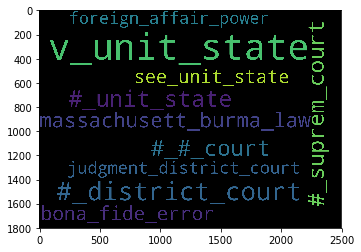

In [348]:
# plot one to see more clearly, will plot all 10 below
wc = WordCloud(width = 2500, height = 1800, max_words = 120)
wc.generate_from_frequencies(dict(topics[1][1]), max_font_size=300)
plt.gca().imshow(wc)
plt.show()


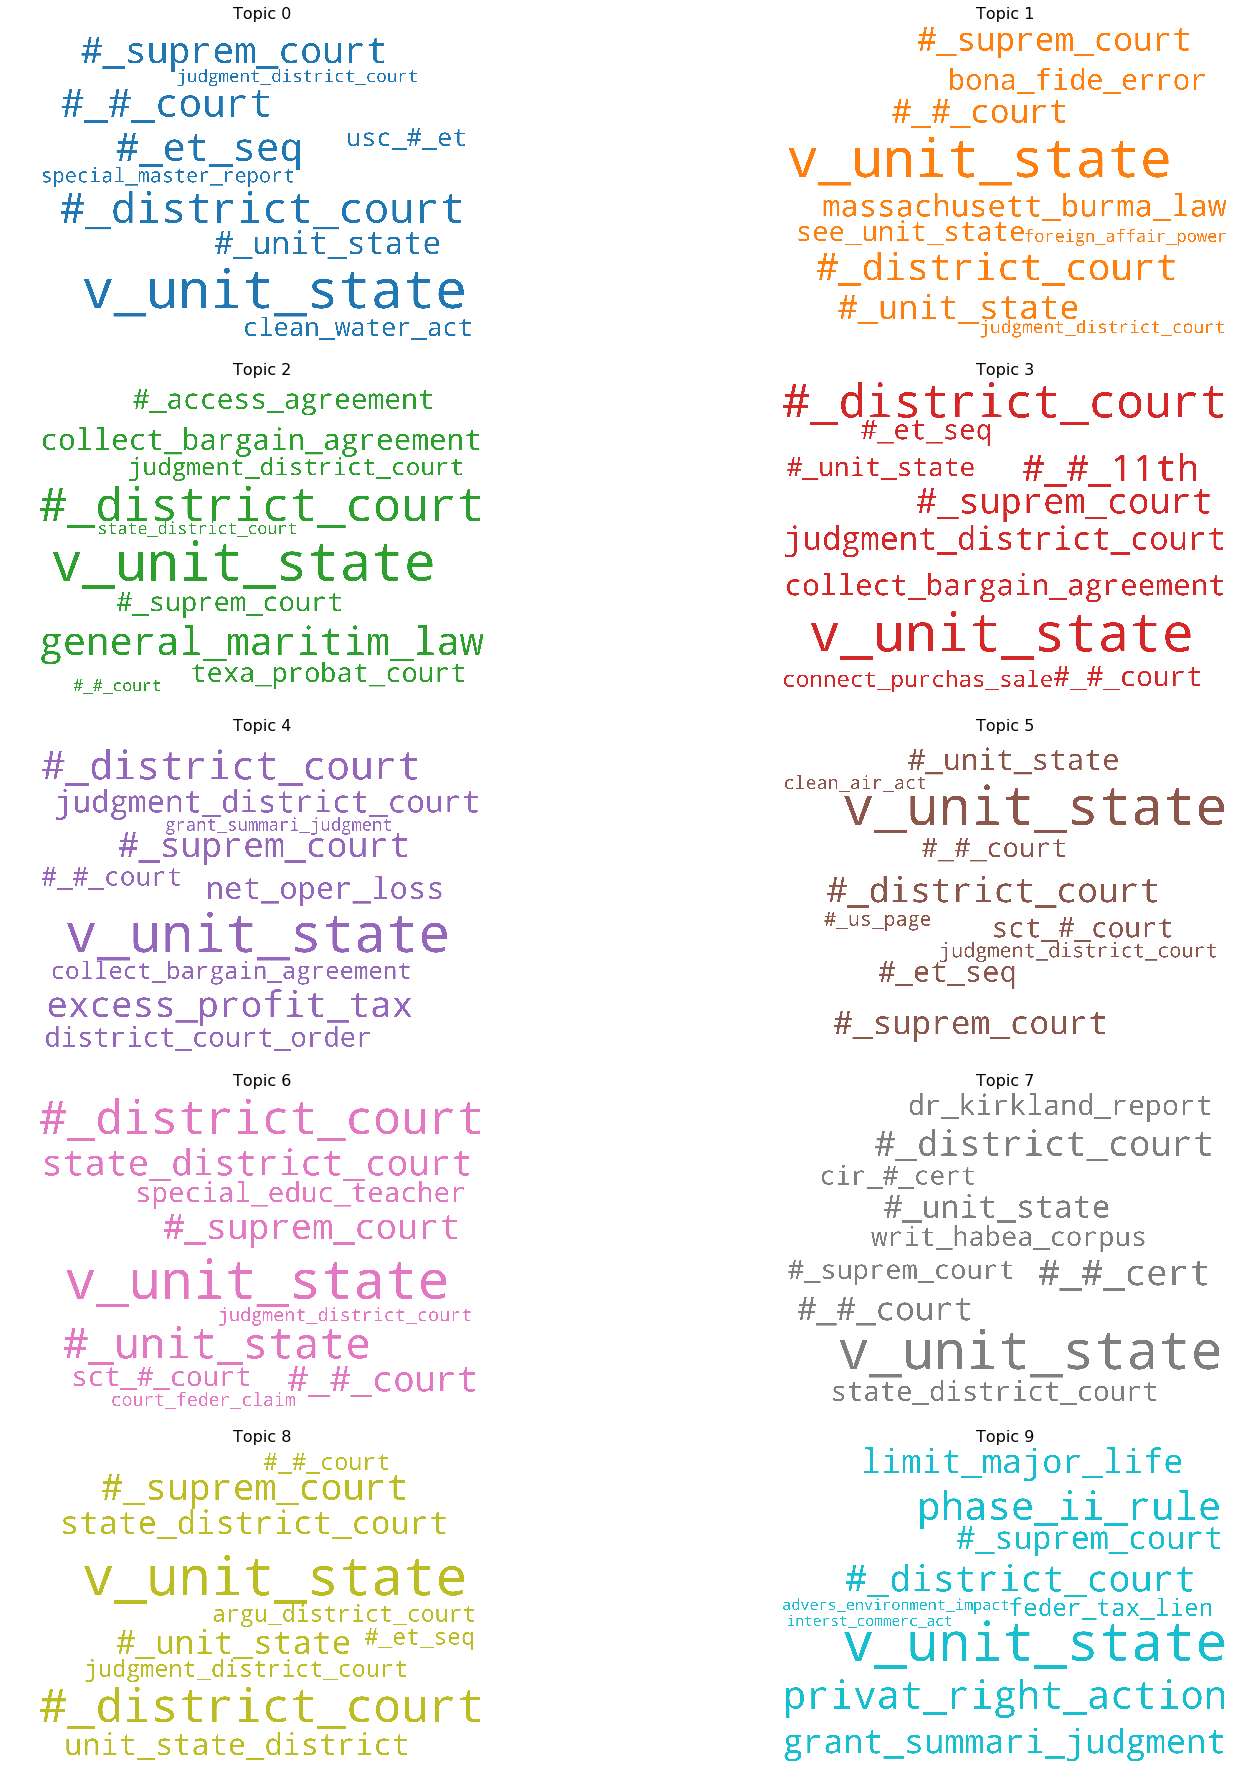

In [349]:
# plot all
fig, axes = plt.subplots(5, 2, figsize=(25,25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [350]:
# redo using only 5 topics     
# each of the 5 clouds has something the others don't, ie. they are enough different and similar
lda5 = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes = 3)
lda5.show_topics(formatted=False)

[(0,
  [('v_unit_state', 0.0013084464),
   ('#_district_court', 0.0007551724),
   ('#_#_court', 0.00045491246),
   ('feder_tax_lien', 0.0004350636),
   ('#_suprem_court', 0.00036066954),
   ('collect_bargain_agreement', 0.00033857833),
   ('judgment_district_court', 0.00033529566),
   ('#_et_seq', 0.00032339338),
   ('#_unit_state', 0.00031705253),
   ('state_district_court', 0.00031308545)]),
 (1,
  [('v_unit_state', 0.0011559038),
   ('#_district_court', 0.0007470423),
   ('#_unit_state', 0.00060383294),
   ('#_#_court', 0.0004394446),
   ('#_suprem_court', 0.00042638078),
   ('judgment_district_court', 0.00039549937),
   ('writ_habea_corpus', 0.0003862102),
   ('state_district_court', 0.0003391633),
   ('see_unit_state', 0.00033759876),
   ('beyond_reason_doubt', 0.00031583215)]),
 (2,
  [('v_unit_state', 0.0020861616),
   ('#_district_court', 0.00081678294),
   ('#_suprem_court', 0.0005865687),
   ('grant_summari_judgment', 0.000554849),
   ('#_unit_state', 0.00052236),
   ('judgme

In [351]:
topics5 = lda5.show_topics(formatted=False)

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

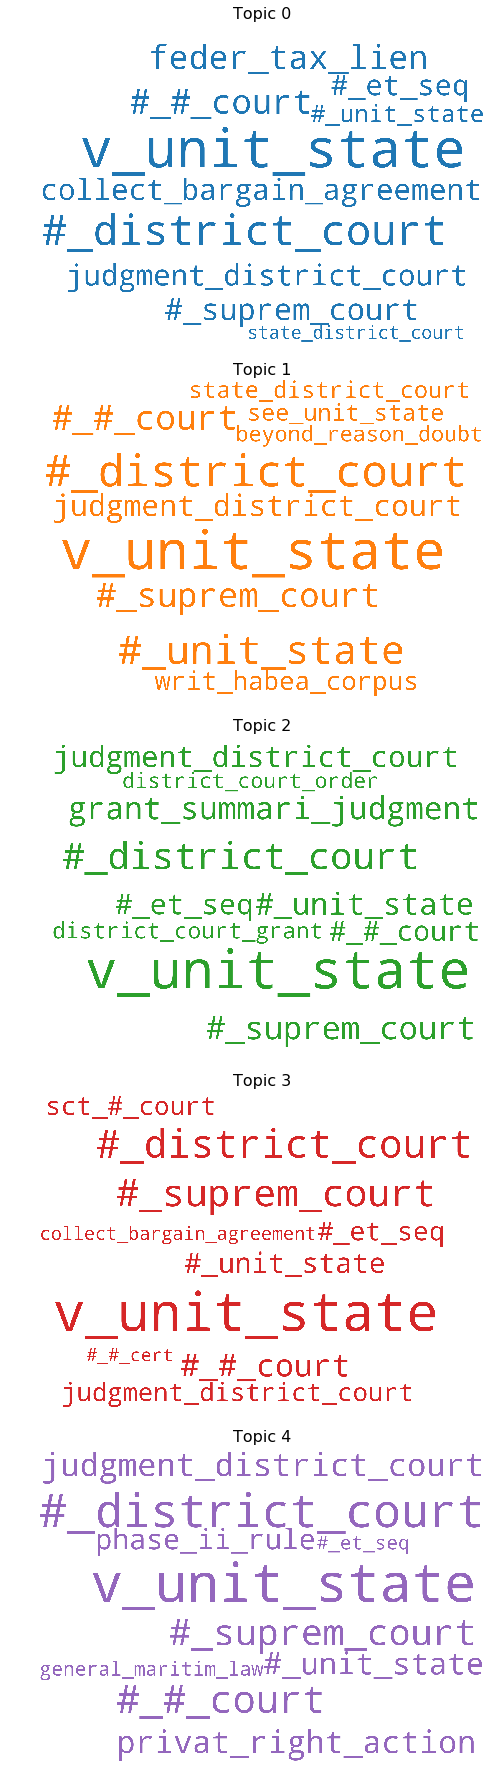

In [352]:
# plot all
fig, axes = plt.subplots(5, 1, figsize=(25,25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics5[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [416]:
#df.to_pickle('p2_df_1k.20190418_1538.pkl')
df3.to_pickle('p2_df3_1k.20190418_1538.pkl')


# problem set2, Question 5 deep learning

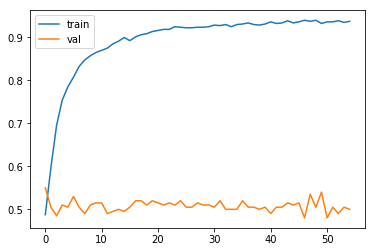

In [418]:
# problem set2, Question 5 deep learning
# the assignment requires one to use softmax

target = df3['rev'].values
tgx = np.zeros((len(target), 2))   # needs more than 1 output in order to use softmax as activation
tgx[:,0] = target               # softmax gives one a probability distribution, sigmoid doesn't 
tgx[:,1] = 1  - tgx[:,0]        # one can^t use categorical_crossentropy as loss if one has only one output
features = df3.loc[:,df3.columns != 'rev']
features_scaled = preprocessing.scale(features, with_mean=False)

msk = np.random.rand(len(df3)) < 0.8
# split into 80 % training set and 20% test set

# training data
targeta = target[msk].astype(int)   # actually not used below because the validation_split already takes car of the splitting
feata = features_scaled[msk]

# test data
targete = target[~msk].astype(int)
feate = features_scaled[~msk]

from keras.models import Sequential
minimal_model = Sequential()

from keras.layers import Dense
# minimal_model: no hidden layer, use l2 regularization, softmax output
from keras.regularizers import l2
minimal_model.add(Dense(units=2, activation='softmax', kernel_regularizer=l2(0.01), activity_regularizer = l2(0.01), input_dim = 1000))

minimal_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

minfit_summary = minimal_model.fit(features_scaled, tgx, epochs = 55, batch_size = 10, validation_split=0.2, verbose=0)
plt.plot(minfit_summary.epoch, minfit_summary.history['acc'])
plt.plot(minfit_summary.epoch, minfit_summary.history['val_acc'])
plt.legend(['train', 'val'], loc='best')
plt.show()

# accuracy on vali set (=0.5413) about the same as in the LogisticRegression above (0.54)
# accuracy on test set (=1) better than in the LogisticRegression above (0.885) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 50)                50000     
_________________________________________________________________
batch_normalization_32 (Batc (None, 50)                200       
_________________________________________________________________
activation_29 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 40)                2040      
_________________________________________________________________
dropout_64 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 2)                 82        
Total para

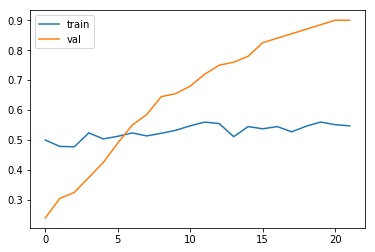

In [451]:
# more elaborate model: add 2 hidden layers, dropout, batch normalization

from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation
from keras.callbacks import EarlyStopping

model2 = Sequential()

model2.add(Dense(50, use_bias=False, input_dim=1000, kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=40, activation='relu', kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01)))
model2.add(Dropout(0.5))

model2.add(Dense(units=2, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

earlystopping_cb = EarlyStopping (monitor = 'val_acc', min_delta=0.001, verbose=0, patience=1, mode='auto')

fit_summary2 = model2.fit(features_scaled, tgx, epochs = 855, batch_size = 100, validation_split=0.2, verbose=0, callbacks=[earlystopping_cb])
plt.plot(fit_summary2.epoch, fit_summary2.history['acc'])
plt.plot(fit_summary2.epoch, fit_summary2.history['val_acc'])
plt.legend(['train', 'val'], loc='best')
plt.show()


In [448]:
predictions = model2.predict(feate)
rev_predicted = np.zeros((len(targete),1))
for i in range(len(targete)):
    if predictions[i, 0] > 0.5 :
        rev_predicted[i] = 1

In [449]:
confusion_matrix(targete, rev_predicted)

array([[  2,  80],
       [  1, 133]])

In [ ]:
# accuracy does not increase a lot  but speed is faster with dropout